# Tutorial for Apache Spark with Python (PySpark)
## Introduction

Big data represents a large collection of data that is not possible to be processed with the traditional data processing applications. Big data has three different characteristics: variety, volume, and velocity. In modern analytics, the trend is now moving towards bringing in as many kinds of data and as much data as possible. The ability of analyzing such data becomes one of the basis for the competition in all areas including business and academy. Data practitioners are now analyzing tweets, follower-followee graph on top of the tranditional relational data everyday to extract insights hidden behind these data set. Although precise analysis of big data can bring valuable insights and improve our lives, processing large amounts of information has been a difficult challenge as data today accumulates at an unprecedented rate. In today, Big Data analytic systems such as Apache Hadoop and Apache Spark are widely used for processing large data to extract insights.

### Apache Hadoop
After the introduction of Google File System and MapReduce programming model by Google, the open source project called 'Apache Hadoop' has quickly emerged as a de-facto standard for big data processing framework. Hadoop consists of distributed file system (HDFS) and processing engine (MapReduce). The main benefit of Hadoop is that users can perform distributed computing over hundreds of nodes by simply implementing map and reduce function while the framework takes care of job scheduling, fault tolerance, or loss prevention. 

### Apache Spark
Apache Spark is the open source big data processing framework that is scalable, fast, and easy-to-use. One of the most important improvement of Spark over Hadoop is that it allows to cache data in-memory for reuse in the future. It introduces an abstraction called Resilient Distributed Data Sets (RDDs). RDDs are imutable objects which are partitioned across the cluster and can be cached in memory for reuse in the distributed setting. RDDs gain fault tolerance by maintaining lineage information that can be used to reconstruct lost partitions. A user can tranform RDDs by combining pre-defined set of operators such as map, group by key, filter, join, and etc. Apache Spark provides its programming API for several languages including Java, Scala, and Python. In this tutorial, we are going to look into Python version (pySpark).

## Installation
- download spark at http://spark.apache.org/downloads.html
- extract the file anywhere you would like to. From now on, I refer this installed path as $SPARK_HOME
    
  **export SPARK_HOME="your path to spark"**
  
    
- restart jupyter using pyspark shell using the following command and open this notebook again from the jupyter.
  
  **PYSPARK_DRIVER_PYTHON="jupyter" PYSPARK_DRIVER_PYTHON_OPTS="notebook" $SPARK_HOME/bin/pyspark**
  

- once the code given below works, we are ready to start to use pyspark. 

Note that we are testing under the local mode of the pyspark. One of the benefit of Spark is that the framework takes in charge of distributing the work over hundreds nodes of the cluster. In other words, the code that we are writing here can automatically run over multiple nodes of cluster.

In [39]:
# import all necessary library for this tutorial
import pyspark
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import string
import nltk


%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen

# check the current directory path that you extract the tar file.
current_directory = os.getcwd()
print current_directory


/Users/shlee0605/688/tutorial


## Resilient Distributed Datasets (RDDs)
As mentioned above, Spark is developed around the data model called Resilient Distributed Datasets (RDDs). RDDs are immutable key-value pairs of 'fault-tolerent' data set that can be processed in parallel. We can either parallelize the existing collections or we can read the data from external sources such as local file system, HDFS (distributed file system), and HBase (NoSQL key-value store). Moreover, there are two different types of operations that we can perform over RDDs: transformation and actions. Transformations are creating new RDD object from the existing ones while actions return the result to the driver program. The full list of transformations and actions that we can trigger is listed at http://spark.apache.org/docs/latest/programming-guide.html#transformations. Since we now have the understanding of basic concepts of Spark and we also have installed it on our system, it is time to start to learn how to perform data analysis using Spark.

## Data Processing with Spark
For this section, we will go over the basic spark programs that computes word counts from text data and degree distribution from graph data. From the examples, we will go over how to create RDD from the external data source and how to use "transformations" and "actions" over RDDs. Spark programming is heavily dependent on using transformations and passing lambda functions for representing logics. This is very similar to the computation over Panda's dataframe. You can refer to the following website for more information on the function passing and closure (about variable scopes): http://spark.apache.org/docs/latest/programming-guide.html#passing-functions-to-spark. Let's first start with the data loading on Spark.

In [2]:
"""
Data Loading
"""

# change path to your file
filePath = "file:///" + current_directory + "/data/pg18.txt"

# read the text file from the external storage and create the RDD 
textFile = sc.textFile(filePath)

# count the number of lines by calling count() which is an "action"
lineCount = textFile.count()

# print out the first 10 lines of text file and the total line count
print lineCount
print textFile.take(10)

25975
[u'The Project Gutenberg EBook of The Federalist Papers, by ', u'Alexander Hamilton and John Jay and James Madison', u'', u'This eBook is for the use of anyone anywhere at no cost and with', u'almost no restrictions whatsoever.  You may copy it, give it away or', u're-use it under the terms of the Project Gutenberg License included', u'with this eBook or online at www.gutenberg.net', u'', u'', u'Title: The Federalist Papers']


### Word Count Example
The algorithm of word count in map-reduce fashion is present below.
1. split line with the space
2. for each word in the line, emit `(word, 1)`
3. group the data based on the key and add the count values in the reduce function

In [3]:
"""
Word Count Example
"""
# compute word count using "transformations"
counts = textFile.flatMap(lambda x: x.split(" ")) \
              .map(lambda x: (x, 1)) \
              .reduceByKey(lambda x, y: x + y)

# print out 20 samples by calling take which is an "action"
print counts.take(20)

[(u'', 7254), (u'delusions.', 1), (u'four', 44), (u'ocean,', 1), (u'proposes,', 1), (u'impera1', 1), (u'towns', 4), (u'vassals', 2), (u'looking', 4), (u'LAST', 1), (u'pardon', 5), (u'granting', 7), (u'pre-eminence', 6), (u'ENDEAVORS', 1), (u'quadruple', 1), (u'"NO', 1), (u'innocence,', 1), (u'dissolution', 14), (u'navigating', 1), (u'co-operation', 11)]


## Spark Internal
Since we now have seen an example of spark program, let's look into Spark internals more in detail to understand how Spark execute this user code on the cluster. Before we dive into the internal of Spark, I list the terms that we should know.

- Driver: A JVM process that is responsible for orchestrating the execution of the job.
- Executor: A JVM process that is responsible for executing tasks.
- Job: A job is the entire user code portion that reads input from the source, run computation over the data, and write output data to the sink.
- Stages: A job is divided into multiple stages. Each stage represents the each computation boundaries (e.g. map, shuffle...etc)
- Tasks: Each stage is further divided into tasks. Each task is usually matched with a partition of data and the task is executed one executor.
- DAG: A user program (transformation / actions over RDDs) is represented as the directed acyclic graph.

The overall life cycle of the spark program is represented below. 

1. A user submit the job using either Spark interactive shell or `spark-job` script.
2. A driver program translates the transforms in the user program into a DAG graph.
3. The graph is submitted to DAG Scheduler, which splits the graph into stages.
4. DAG scheduler submits each stage to task scheduler once it is ready to execute.
5. Task Scheduler then assigns tasks to executor via cluster manager and it also keeps track of the status of the tasks. If the executor fails to execute the task, the schduler would assign the task to another executor in order to acheive fault tolerance.
6. Executors execute tasks and write output to the distributed file system or send the result to driver based on user's action.



![spark2](img/3.png)

The image is taken from the slide by Databricks, which is the company that develops Apache Spark. (http://files.meetup.com/3138542/dev-meetup-dec-2012.pptx)


## More Examples
### Tweet Sentiment Analysis
In this section, we will implement the tweets sentiment analysis that categorize the tweets into positive and negative tweets. For the score of each positive/negative word, I got the list from http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010. This spark program processes the raw tweets data, and compute the sentiment score for each tweet based on the score from the above source.



In [44]:
"""
Tweet Sentiment Analysis
"""

def text_process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    text = text.encode('ascii','ignore')
    text = text.lower()
    text = text.replace("'s", "")
    text = text.replace("'", "")
    test_trans = " " * len(string.punctuation)
    text = text.translate(string.maketrans(string.punctuation,test_trans))  
    
    tokens = nltk.word_tokenize(text)
    result = []
    for i in range(0, len(tokens)):
        try:
            result.append(lemmatizer.lemmatize(tokens[i]))
        except:
            continue
    return result

def parse_senti_score(path):
    # read sentiment score
    senti_file = open(sentiScorePath, "rb")
    senti_lookup = {}
    for line in senti_file:
        cols = line.split("\t")
        senti_lookup[cols[0]] = int(cols[1])
    return senti_lookup

def split(s):
    cols = s.split(",")
    return cols[-1]

def compute_senti(s, senti_lookup):
    lookup_table = senti_lookup.value
    
    words = text_process(s)
    score = 0
    for word in words:
        if word in lookup_table:
            score += lookup_table[word]
    return (score, s)

# read raw edges file to form RDD
senti_score_path = current_directory + "/data/AFINN-111.txt"
tweet_file_path = "file:///" + current_directory + "/data/tweets.csv"

# using a broadcast variable for distributed lookup table
senti_score = parse_senti_score(senti_score_path)
senti_lookup = sc.broadcast(senti_score)

# read the data
data = sc.textFile(tweet_file_path)
header = data.first()
tweets = data.filter(lambda x: x != header) \
             .map(split)

# compute sentiment
senti_tweets = tweets.map(lambda x: compute_senti(x, senti_lookup))

# filter tweets with positive score, negative score and sort them in order
positive_tweets = senti_tweets.filter(lambda x: x[0] > 0).sortByKey(False)
negative_tweets = senti_tweets.filter(lambda x: x[0] < 0).sortByKey(True)

# print out top 5 positive/negative tweets
print "Positive Tweets"
for tweet in positive_tweets.take(5):
    print tweet[0], "-", tweet[1]

print
print "Negative Tweets"
for tweet in negative_tweets.take(5):
    print tweet[0], ":", tweet[1]


Positive Tweets
17 - We're thrilled to unveil the stunning restoration of this iconic landmark. Thank you to our brilliant team @TrumpDC! https://t.co/loToqDulGj
16 - "Ireland! You were outstanding. Blessed to play along side such amazing acts for such a warm crowd. I hope you had as much fun as we did. 
15 - Thank you to Perform Better for the opportunity to present and share with all of these fantastic fit pros! Great... https://t.co/cjLelhpugI
15 - RT @realDonaldTrump: It is wonderful to be in beautiful Doonbeg touring @Trump_Ireland. I'm truly honored by the wonderful welcome to my fa…
15 - Another awesome week in Canada. Thanks to @RBCCanadianOpen for a wonderful event &amp; the fans who always make me feel like one of their own!

Negative Tweets
-10 :  killed Sunday (9-11) in Fresno and my wife's heartbroken plea to end gun violence. http…"
-9 : WATCH NOW: @realDonaldTrump spoke to victims of illegal immigrant crime at the Remembrance Project in Houston. https://t.co/IgsE0kZvFn
-

### Degree Distribution
For the next example, we use graph data processing using Spark. We are loading the data from HW2 (edges.csv), compute degree distribution and present the graph in order to validate the correctness.

screen_name,friend


(array([   2.,    6.,    2.,    5.,    4.,    4.,    3.,    1.,    4.,  148.]),
 array([   2. ,   11.8,   21.6,   31.4,   41.2,   51. ,   60.8,   70.6,
          80.4,   90.2,  100. ]),
 <a list of 10 Patch objects>)

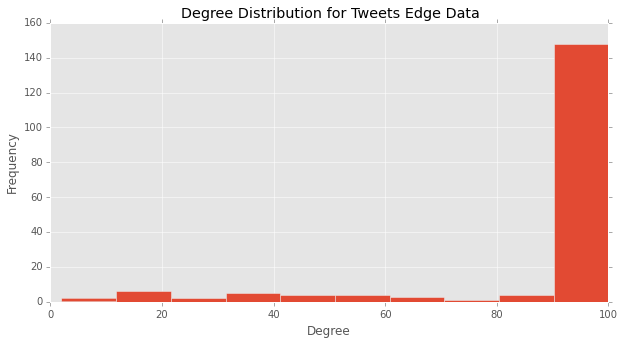

In [13]:
"""
Degree Distribution Computation
"""

# read raw edges file to form RDD
edgeFilePath = "file:///" + current_directory + "/data/edges.csv"
data = sc.textFile(edgeFilePath)
header = data.first()
edges = data.filter(lambda x: x != header) \
            .mapPartitions(lambda x: csv.reader(x))

# compute degree distribution using transformations
degree = edges.groupByKey() \
              .map(lambda x: len(x[1]))

# retrieve the distribution data.
final_data = degree.collect()

# compute group by
plt.title("Degree Distribution for Tweets Edge Data")
plt.xlabel("Degree", size=12)
plt.ylabel("Frequency", size=12)
plt.hist(final_data)

### Complex Iterative Graph Processing (Connected Components)
Since we now know how to use basic Spark's programming APIs including transformations and actions, it is time to move to the complex example. For this section, I implment the connected components algorithm that is iterative in nature. I implement 'Hash-to-Min' algorithm introduced in https://arxiv.org/pdf/1203.5387.pdf. This algorithm uses the propagating mechanism to compute the connected components. The detailed explanation of the algorithm can be found in page 3 of the paper. 

In [5]:
"""
Connected Components
"""

# split function that is used to pre-process the input data
def split(s):
    nodes = s.split("\t")
    return ((int(nodes[0]), int(nodes[1])), (int(nodes[1]), int(nodes[0])))

# initialize the C_v
def initialize_Cv(n):
    return (n[0], set(n[1]) | set([n[0]]))

# computing hash function based on the hash algorithm in the paper
def compute_hash(s):
    vertex = s[0]
    neighbors = s[1]
    neighbor_min = min(neighbors)
    result = []
    for n in neighbors:
        if n != neighbor_min:
            result.append((n, set([neighbor_min])))
    result.append((neighbor_min, neighbors))
    for n in neighbors:
        if neighbor_min != n:
            result.append((n, set([neighbor_min])))
    return result

# filtering case
def export(v):
    vertex = v[0]
    neighbor_min = min(v[1])
    if neighbor_min == vertex:
        return True
    return False

def compute_connected_components(file_path, num_iter, print_list):
    # read raw edges file to form RDD
    data = sc.textFile(file_path)
    
    # create adjacency list (node -> list of neighbors)
    graph = data.flatMap(split) \
                .distinct() \
                .groupByKey()

    # initialize connected component result (C_v in the paper)
    connected_result = graph.map(initialize_Cv)
    
    # start the iteration
    for i in range(num_iter):
        # map phase of the algorithm
        intermediate = connected_result.flatMap(lambda s: compute_hash(s))

        # reduce phase
        connected_result = intermediate.reduceByKey(lambda a,b: a | b)

    # filtering out unnecessary output
    filtered_output = connected_result.filter(lambda v: export(v))

    final_collected_result = filtered_output.collect()
    if print_list:
        for x in final_collected_result:
            print list(x[1])
    else:
        print len(final_collected_result)


In [6]:
# verify with the small data set :
# (0,1), (1,2), (2,3), (4,5), (5,6), (7,8)
# this example should yield three groups: [0,1,2,3], [4,5,6], [7,8]
simple = "file:///" + current_directory + "/data/simple-graph.txt"
tweet_edge = "file:///" + current_directory + "/data/tweet-edges.txt"

print "simple example verification"
compute_connected_components(simple, 10, True)

simple example verification
[0, 1, 2, 3]
[4, 5, 6]
[8, 7]


Since we now have the spark implementation to compute connected components, let's run this algorithm over the existing data. For this task, I will use the edges.csv data from HW2 which is the follower-followee graph data. In order to use the data into our implementation, we first need to convert the data format.

In [7]:
raw_edges_file = open(current_directory + "/data/edges.csv", "rb")

# print first two lines
print raw_edges_file.readline()
print raw_edges_file.readline()

# close file
raw_edges_file.close()

screen_name,friend

realDonaldTrump,Trump



Our implementation assumes that the edges are represented as (follower(int), followee(int)). So, from the above example, we need convert (realDonaldTrump,Trump) -> (0,1). Let's convert this data into the correct format.

In [9]:
# open the files
raw_edges_file = open(current_directory + "/data/edges.csv", "rb")
processed_edges_file = open(current_directory + "/data/processed_edges.txt", "wb")

# ignore the first line
raw_edges_file.readline()

mapping_table = {}
count = 0
for line in raw_edges_file:
    splits = line.split(',')
    if splits[0] not in mapping_table.keys():
        mapping_table[splits[0]] = count
        count += 1
    if splits[1] not in mapping_table.keys():
        mapping_table[splits[1]] = count
        count +=1
    converted_line = str(mapping_table[splits[0]]) + "\t" + str(mapping_table[splits[1]]) + "\n"
    processed_edges_file.write(converted_line)
    
raw_edges_file.close()
processed_edges_file.close()

# this example uses the tweet edge data given from hw2 - string names(nodes) are converted to number.
# expected output: 6
processed_edge_data_path = "file:///" + current_directory + "/data/processed_edges.txt"
print "connected components of tweet edges data: "
compute_connected_components(processed_edge_data_path, 10, False)

connected components of tweet edges data: 
6


## Summary and Useful References
This tutorial covers how to use Spark programming API to write the data processing logic. Although I used the small data sets for examples, the beauty of Apache Spark is that all the code we wrote in this tutorial can be run on over tens or hundreds of machines to process extremely large data set. 

For deploying Spark cluster, one can choose to use his/her own servers by manually installing spark on their machines. Easier way is to use AWS EMR service, which allows a user to deploy Spark cluster with several clicks. The detailed information can be found at https://aws.amazon.com/emr/details/spark/.

- Spark Programming Guide: http://spark.apache.org/docs/latest/programming-guide.html
- Spark Paper ("Resilient Distributed Datasets"): http://www-bcf.usc.edu/~minlanyu/teach/csci599-fall12/papers/nsdi_spark.pdf
- Finding Connected Components in Map-Reduce in Logarithmic Rounds: https://arxiv.org/pdf/1203.5387.pdf